# RQ3: Reskilling intensity
Felix Zaussinger | 15.06.2021

## Core Analysis Goal(s)
1. How close are occupations likely less demanded in a green transition to those being more demanded? (~ reskilling intensity)
2. Further disaggregate the analysis to the ISCO-08 1-digit level groups?

## Key Insight(s)
1. Ranking of average similarities is surprising. Only looking at occupation similarity, brown occupations are on average closer to green occupations than neutral occupations.
    - Neutral & Green
    - Brown & Green
    - Brown & Neutral
2. Cross-pair differences are statistically significant at p < 0.001
3. Between-pair differences not significant at p < 0.001 are neutral-green and green-brown
4. Results are not robust to changing the similarity matrix (upeksha vs kanders).
using Upeksha's matrix, green-brown is closest, followed by green-neutral and neutral-brown

In [78]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
import scipy
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [44]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [45]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [180]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

df_metadata.greenness_vona_2018_v2 = df_metadata.greenness_vona_2018_v2.fillna(0)

# convert job zone to categorical var
#df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)
df_metadata.isco_level_1 = pd.Categorical(df_metadata.isco_level_1, ordered=False)
df_metadata.isco_level_2 = pd.Categorical(df_metadata.isco_level_2, ordered=False)

In [47]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)

In [48]:
sim_upeksha = pd.read_csv(
    os.path.join(data_processed, "occupation_adjacency_upeksha.csv"),
    index_col=0
).values

np.fill_diagonal(sim_upeksha, 0)

In [181]:
# brown occupations
df_brown = pd.read_csv(
    os.path.join(data_interim, "occupations_brown_vona_esco.csv"),
    index_col=0
)

In [182]:
# add brown occupation classification
df_brown["is_brown"] = np.ones(df_brown.shape[0], dtype=bool)

# merge
df_metadata = pd.merge(
    df_metadata,
    df_brown[["concept_uri", "is_brown"]],
    how="left",
    on="concept_uri"
)

df_metadata.is_brown = df_metadata.is_brown.fillna(False)
df_metadata["is_green"] = df_metadata.greenness_vona_2018_v2 > 0
df_metadata["is_neutral"] = (df_metadata.is_green == False) & (df_metadata.is_brown == False)

# drop duplicates
df_metadata = df_metadata.drop_duplicates(subset=["concept_uri"])

In [201]:
# 8ung: there are 30 occupations that have been matched to both brown and green
# the neutral occupations are fine! have to make decision on where to map the
# ambiguous cases
query = (df_metadata.is_brown == True) & (df_metadata.is_green == True)

df_metadata.query("is_brown == True & is_green == True").to_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn_ambiguous_cases.csv")
)

# --> define ambiguous cases as brown as a first solution
df_metadata.loc[query, "is_green"] = False

In [203]:
query = (df_metadata.is_brown == True) & (df_metadata.is_green == True)
df_metadata.loc[query]

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral


In [204]:
df_metadata.to_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv")
)

#### Number of green/brown/neutral occupations per ISCO 1-digit group

In [184]:
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

In [212]:
# table for overleaf document
cols = ["preferred_label", "isco_level_1", "is_brown", "is_green", "is_neutral"]
df_sub = df_metadata[cols]
#df_sub["isco_level_1_txt"] = df_sub.isco_level_1.replace(isco_lvl1_mapping)

df_sub_counts = df_sub.groupby("isco_level_1").sum().reset_index()
df_sub_counts["isco_level_1_txt"] = [isco_lvl1_mapping[val] for val in df_sub_counts.isco_level_1.values]

count_sums =  df_sub_counts[["is_brown", "is_green", "is_neutral"]].sum(axis=1)
col_order = ["isco_level_1", "isco_level_1_txt", "is_brown"]
count_sums
df_sub_counts["is_brown_pc"] = (df_sub_counts["is_brown"] / count_sums) * 100
df_sub_counts["is_green_pc"] = (df_sub_counts["is_green"] / count_sums) * 100
df_sub_counts["is_neutral_pc"] = (df_sub_counts["is_neutral"] / count_sums) * 100

# store
df_sub_counts.to_excel(
    os.path.join(data_processed, "occupation_group_by_isco_lvl1.xlsx")
)

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,500.0,-48000.0,316500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,True,False
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
2965,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0,False,True,False
2966,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,0.0000,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230,M,141000.0,179000.0,-27000.0,-141000.0,152000.0,744000.0,579000.0,-497000.0,-744000.0,82000.0,False,False,True
2967,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,0.0000,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True


## Determine closest matches based on skill similiarity

In [53]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

## Iterate over all occupations and compute avg reskilling intensities

In [54]:
ids_brown = df_metadata.loc[df_metadata.is_brown == True, :].id.values
ids_green = df_metadata.loc[df_metadata.is_green == True, :].id.values
ids_neutral = df_metadata.loc[df_metadata.is_neutral == True, :].id.values

#### Case 1: Brown - Green

In [55]:
sim_matrix = sim_kanders

In [56]:
sim_brown_green = []
for b in tqdm(ids_brown):
    for g in ids_green:
        sim_brown_green.append(sim_matrix[b, g])

np.mean(sim_brown_green)

sim_green_brown = []
for b in tqdm(ids_brown):
    for g in ids_green:
        sim_green_brown.append(sim_matrix[g, b])

np.mean(sim_green_brown)

100%|██████████| 420/420 [00:00<00:00, 4316.42it/s]


0.16988613657676613

#### Case 2: Brown - Neutral

In [57]:
sim_brown_neutral = []
for b in tqdm(ids_brown):
    for n in ids_neutral:
        sim_brown_neutral.append(sim_matrix[b, n])

np.mean(sim_brown_neutral)

sim_neutral_brown = []
for b in tqdm(ids_brown):
    for n in ids_neutral:
        sim_neutral_brown.append(sim_matrix[n, b])

np.mean(sim_neutral_brown)

100%|██████████| 420/420 [00:00<00:00, 856.86it/s]


0.14792975518696236

#### Case 3: Neutral - Green

In [58]:
sim_neutral_green = []
for n in tqdm(ids_neutral):
    for g in ids_green:
        sim_neutral_green.append(sim_matrix[n, g])

np.mean(sim_neutral_green)

sim_green_neutral = []
for n in tqdm(ids_neutral):
    for g in ids_green:
        sim_green_neutral.append(sim_matrix[g, n])

np.mean(sim_green_neutral)

100%|██████████| 2147/2147 [00:00<00:00, 4576.21it/s]


0.17630021383505684

#### Combine in single df

In [59]:
def pad(seq, target_length, padding=None):
    length = len(seq)
    seq.extend([padding] * (target_length - length))
    return seq

In [60]:
df = pd.DataFrame(index=range(len(sim_neutral_green)))
df["sim_green_brown"] = pad(sim_green_brown, len(sim_neutral_green), np.nan)
df["sim_brown_green"] = pad(sim_brown_green, len(sim_neutral_green), np.nan)

df["sim_brown_neutral"] = pad(sim_brown_neutral, len(sim_neutral_green), np.nan)
df["sim_neutral_brown"] = pad(sim_neutral_brown, len(sim_neutral_green), np.nan)

df["sim_neutral_green"] = pad(sim_neutral_green, len(sim_neutral_green), np.nan)
df["sim_green_neutral"] = pad(sim_green_neutral, len(sim_neutral_green), np.nan)

#### Visualisations

In [110]:
df.median().sort_values(ascending=False)


sim_neutral_green    0.173166
sim_green_neutral    0.173010
sim_green_brown      0.160896
sim_brown_green      0.159202
sim_neutral_brown    0.140925
sim_brown_neutral    0.140385
dtype: float64

In [100]:
scipy.stats.shapiro(
    df.sim_neutral_green.dropna().values
)

/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9627436995506287, pvalue=0.0)

((array([-4.80631784, -4.62579332, -4.5281723 , ...,  4.5281723 ,
          4.62579332,  4.80631784]),
  array([3.32131816e-10, 3.74711063e-10, 3.94904626e-10, ...,
         8.75067614e-01, 9.18009961e-01, 9.18009961e-01])),
 (0.06477239476683823, 0.14792975518696233, 0.9706873245302423))

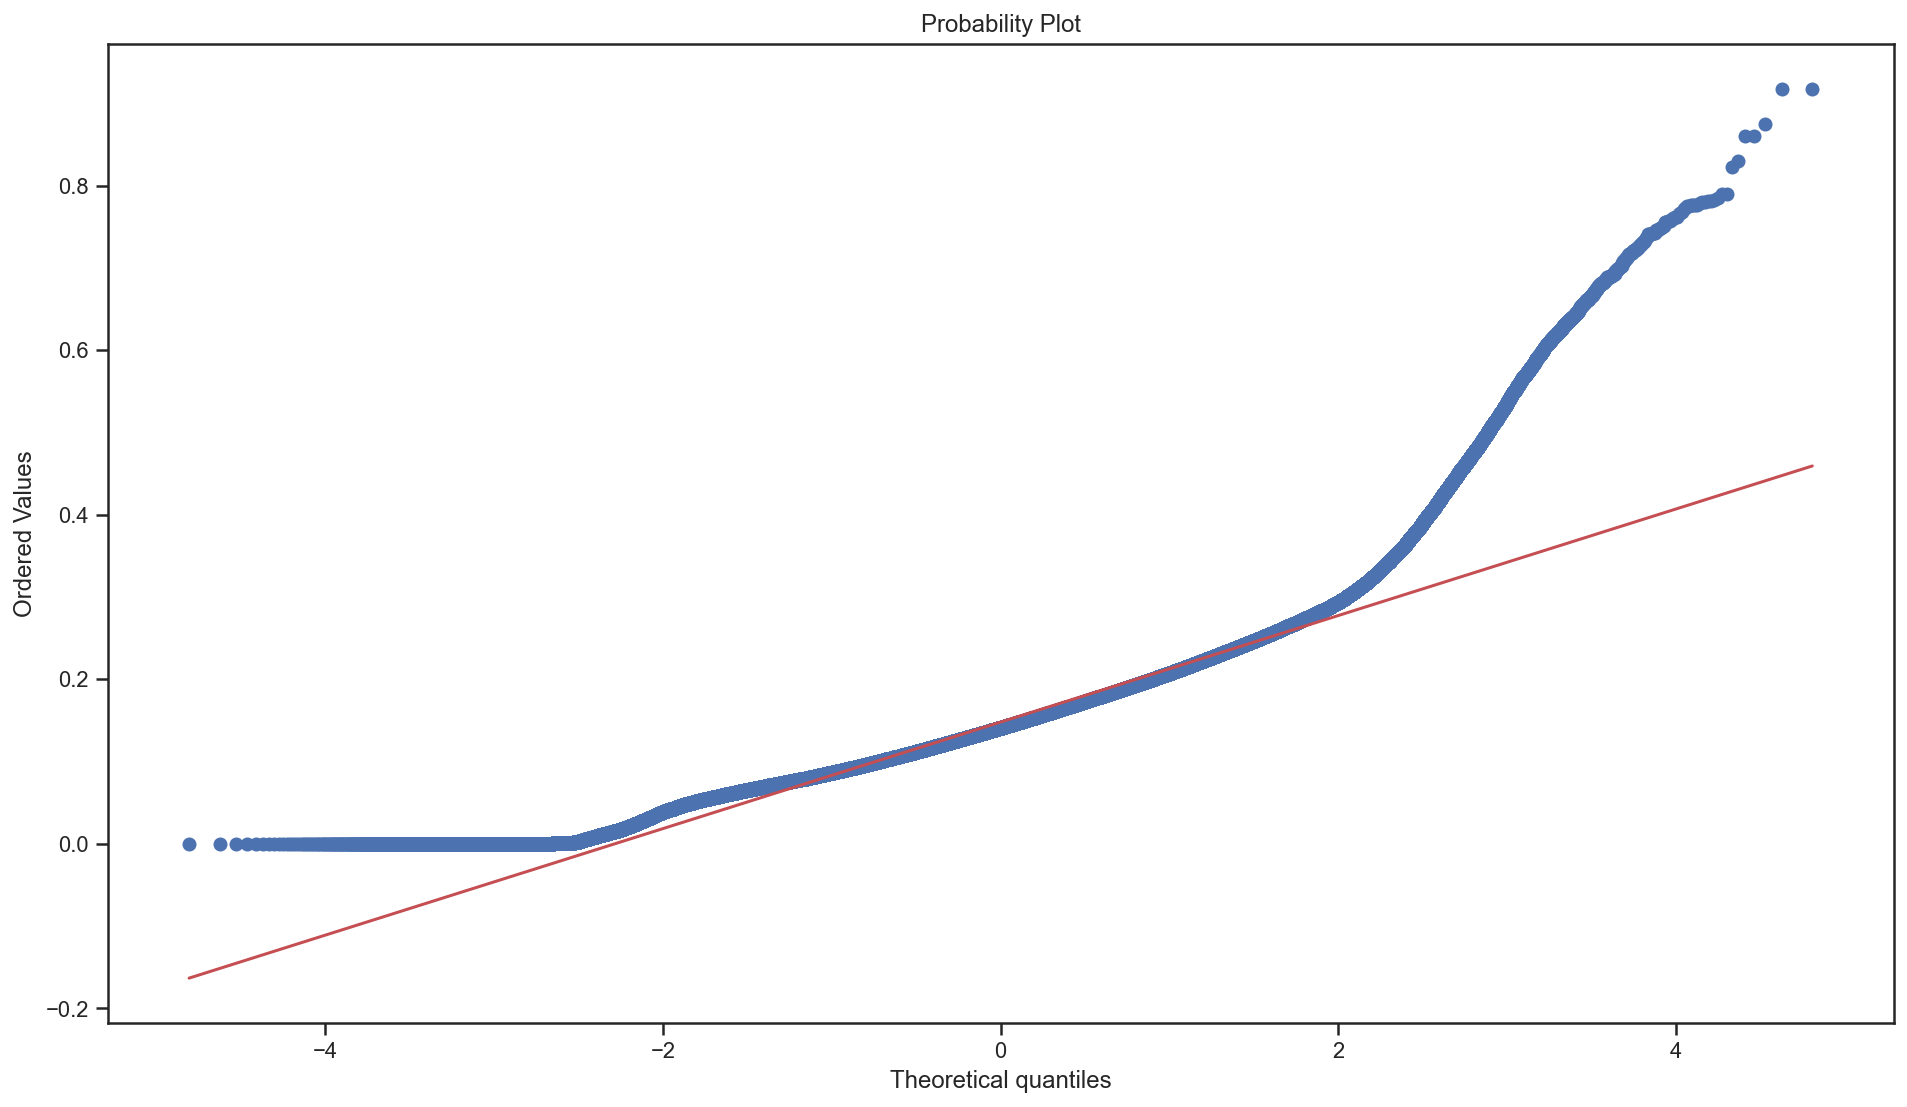

In [101]:
scipy.stats.probplot(df.sim_neutral_brown.dropna().values, dist="norm", plot=plt)

In [124]:
df.median().sort_values(ascending=False)

sim_neutral_green    0.173166
sim_green_neutral    0.173010
sim_green_brown      0.160896
sim_brown_green      0.159202
sim_neutral_brown    0.140925
sim_brown_neutral    0.140385
dtype: float64

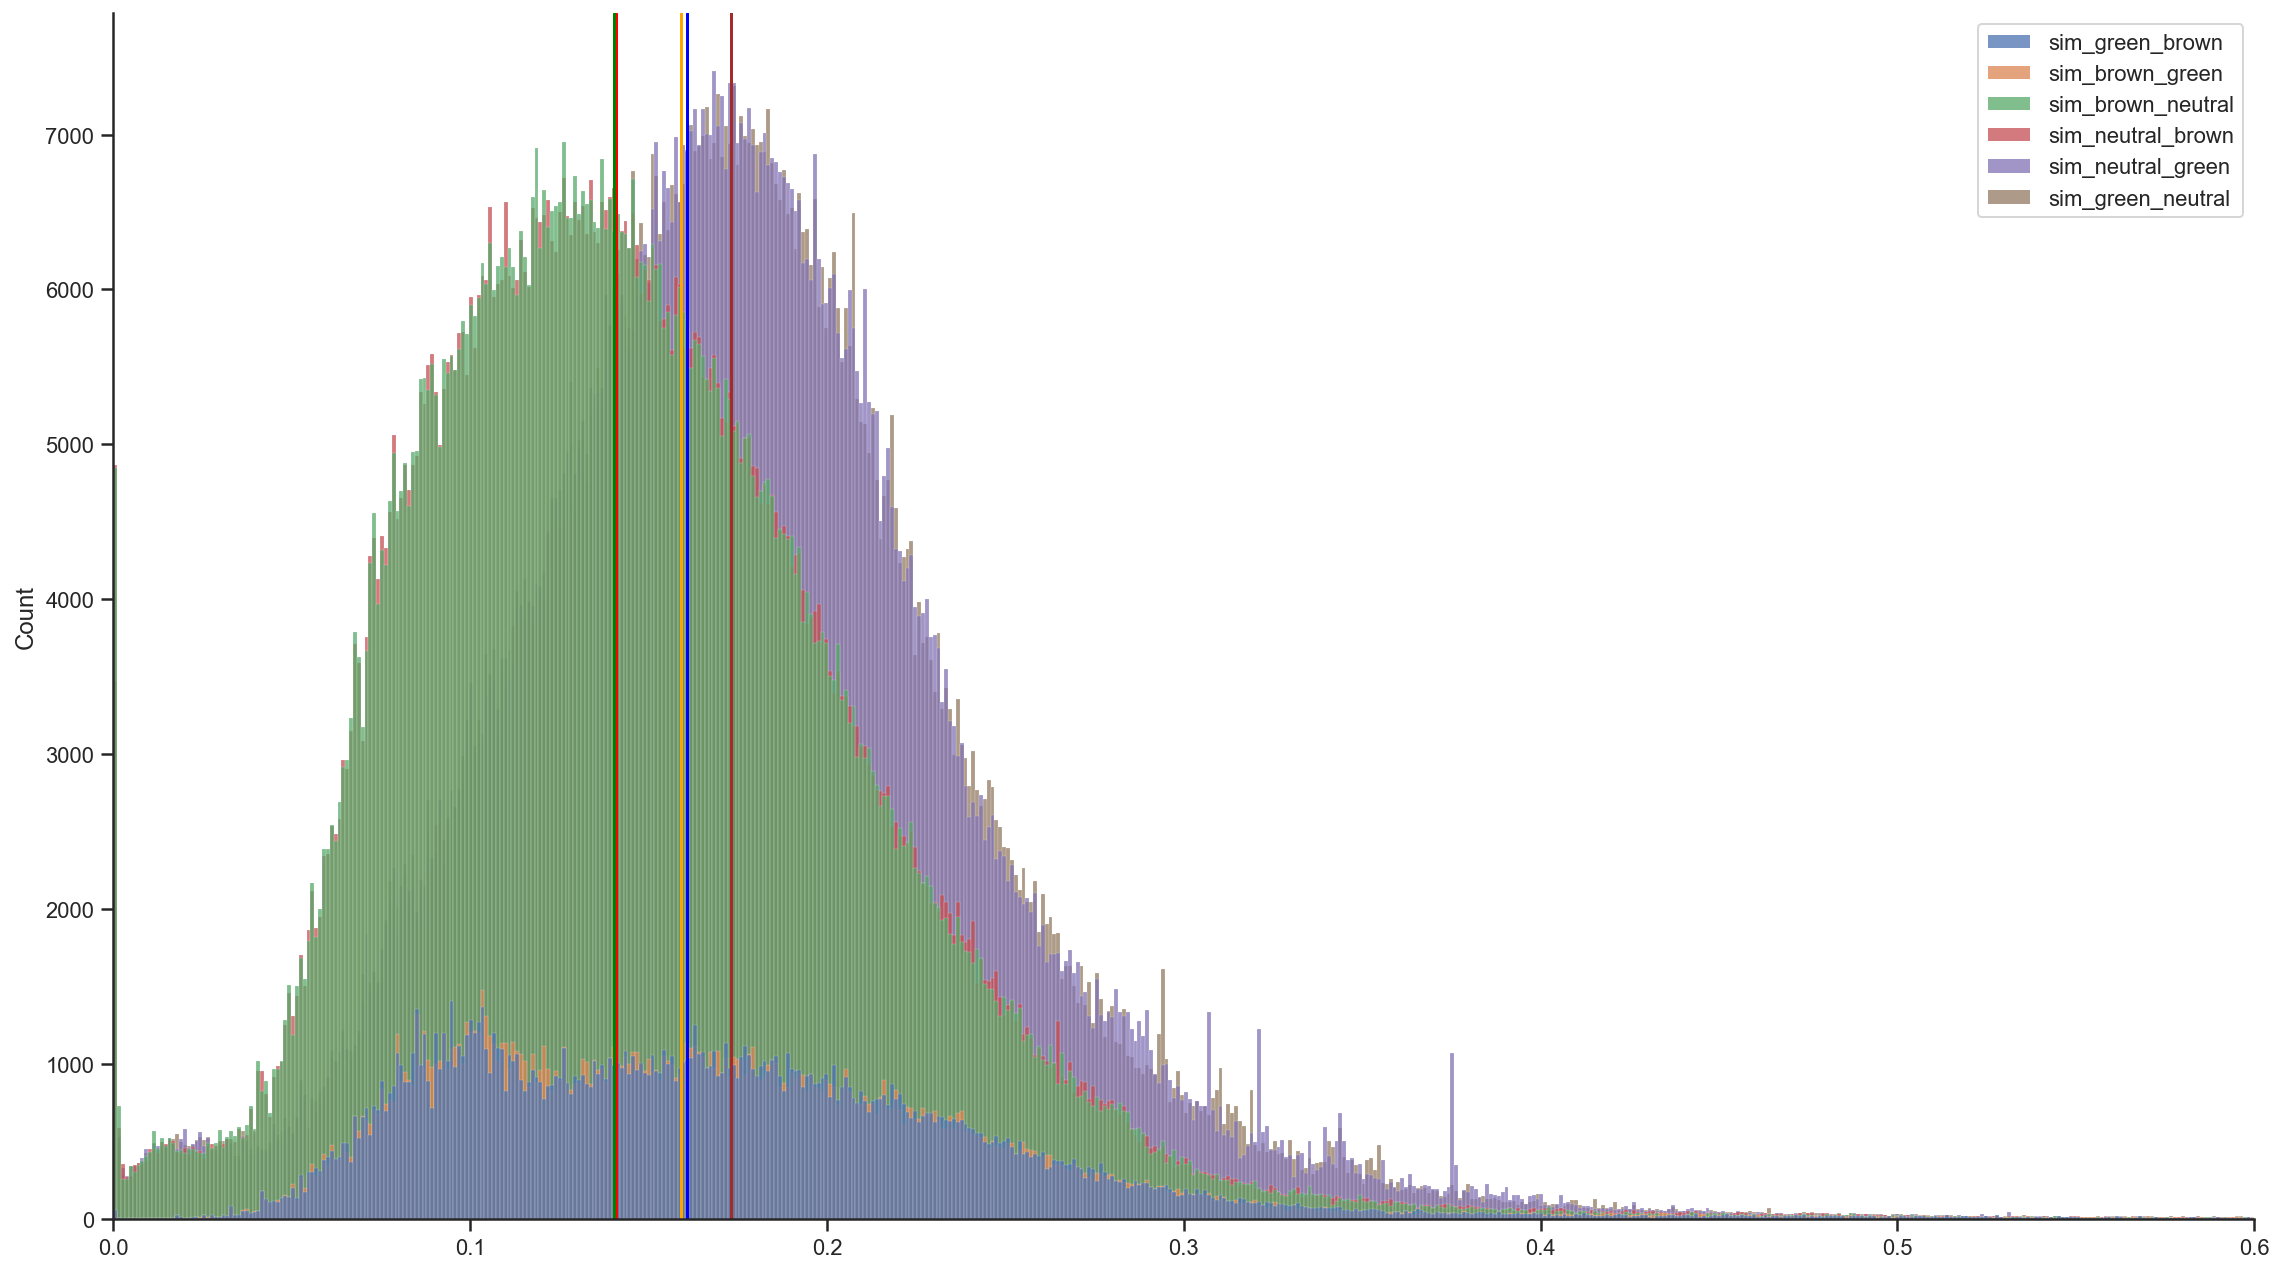

In [126]:
ax = sns.histplot(
    data=df,
    stat="count"
)

vline_colors = ["purple", "brown", "blue", "orange", "red", "green"]
for val, color in zip(df.median().sort_values(ascending=False).values, vline_colors):
    ax.axvline(val, color=color)

ax.set_xlim(0, 0.6)
sns.despine()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ3", "avg_sims_histogram.png"),
    bbox_inches="tight",
    dpi=150
)

<AxesSubplot:>

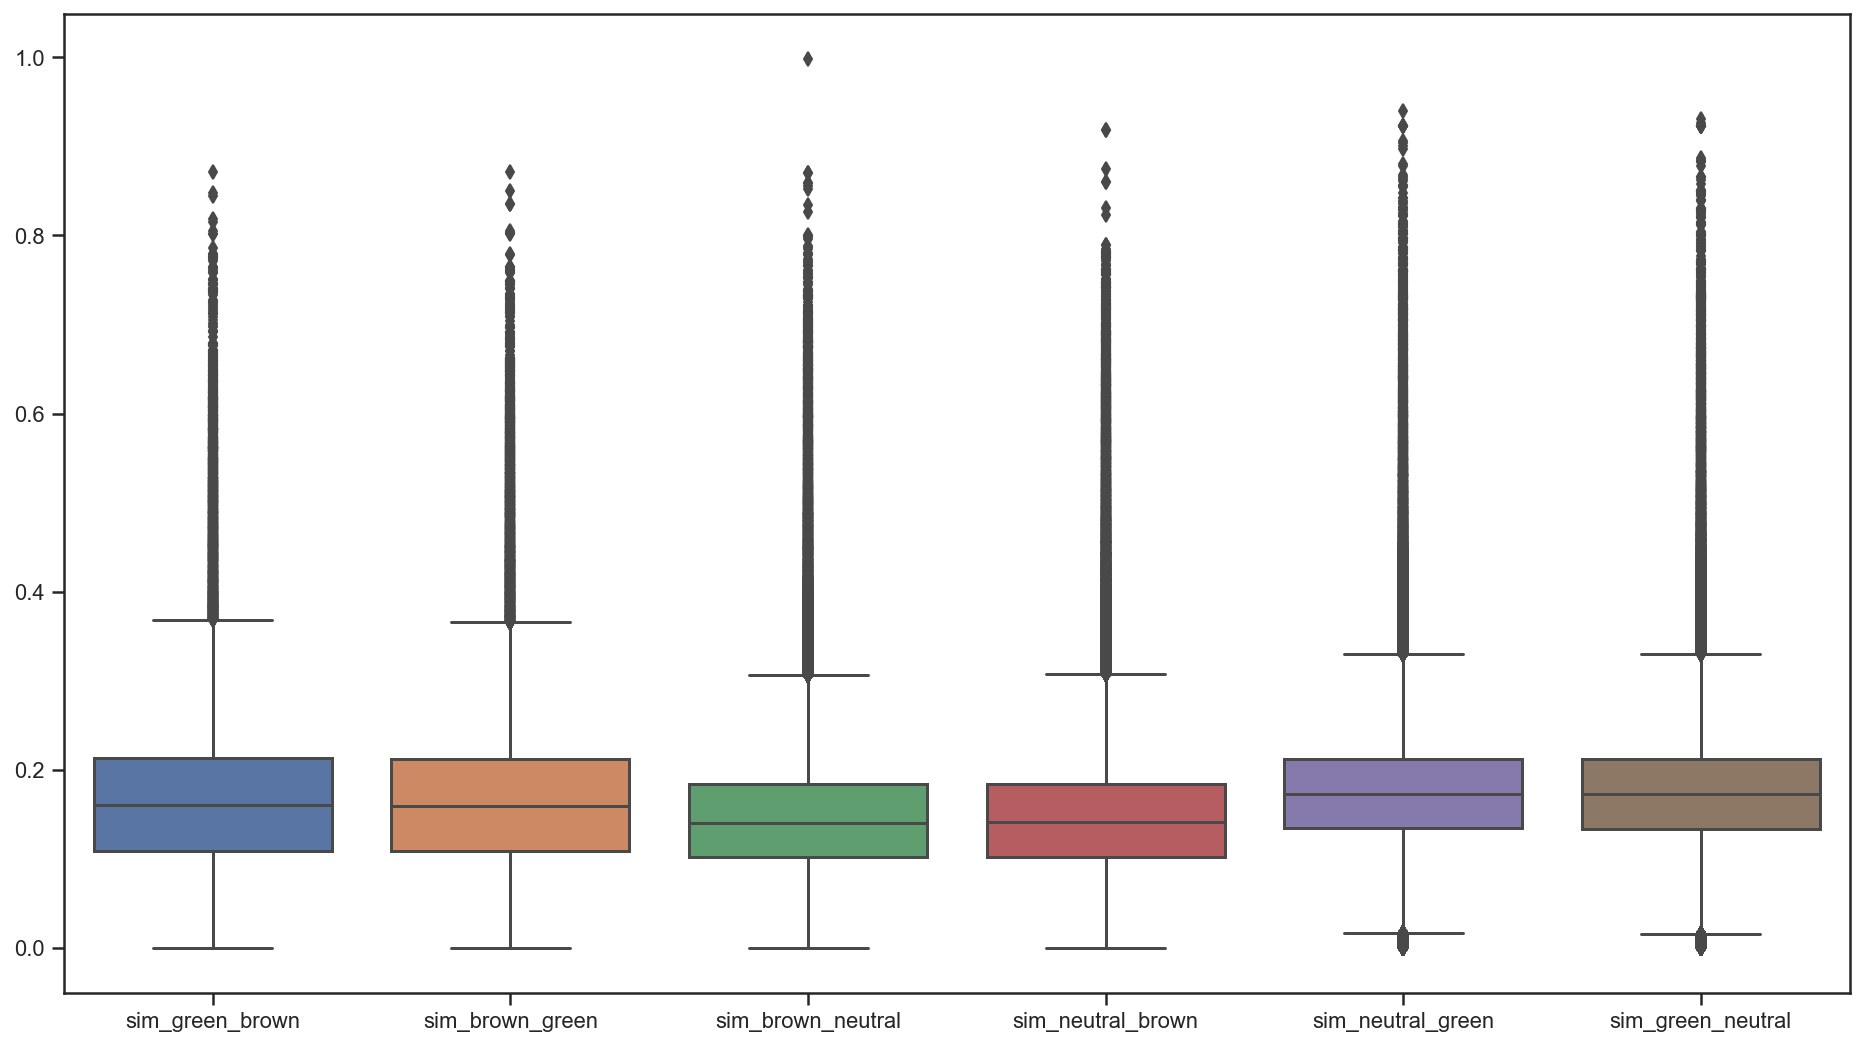

In [63]:
sns.boxplot(
    data=df,
)

#### Difference of central tendencies and post-hoc tests

In [66]:
# ANOVA
scipy.stats.f_oneway(
    df.sim_brown_green.dropna().values,
    df.sim_brown_neutral.dropna().values,
)

F_onewayResult(statistic=15716.48919088317, pvalue=0.0)

In [67]:
# Tukey-HSD
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(
    df.melt().dropna().value,
    df.melt().dropna().variable
)
post_hoc_res = comp.tukeyhsd(alpha=0.001)
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
sim_brown_green,sim_brown_neutral,-0.0219,0.001,-0.0226,-0.0212,True
sim_brown_green,sim_green_brown,0.0009,0.0021,-0.0,0.0018,False
sim_brown_green,sim_green_neutral,0.0073,0.001,0.0066,0.008,True
sim_brown_green,sim_neutral_brown,-0.0211,0.001,-0.0218,-0.0204,True
sim_brown_green,sim_neutral_green,0.0076,0.001,0.0069,0.0083,True
sim_brown_neutral,sim_green_brown,0.0228,0.001,0.0221,0.0235,True
sim_brown_neutral,sim_green_neutral,0.0292,0.001,0.0288,0.0296,True
sim_brown_neutral,sim_neutral_brown,0.0008,0.001,0.0004,0.0013,True
sim_brown_neutral,sim_neutral_green,0.0295,0.001,0.0291,0.0299,True
sim_green_brown,sim_green_neutral,0.0064,0.001,0.0057,0.0071,True


In [122]:
# Kruskall-Wallis H-test
scipy.stats.kruskal(
    df.sim_brown_green.dropna().values,
    df.sim_green_brown.dropna().values,
    df.sim_brown_neutral.dropna().values,
    df.sim_neutral_brown.dropna().values,
    df.sim_green_neutral.dropna().values,
    df.sim_neutral_green.dropna().values,
)

KruskalResult(statistic=201936.28683835382, pvalue=0.0)

In [119]:
import scikit_posthocs as sp

dfm = df.melt(var_name="groups", value_name="values").dropna(subset=["values"])

sp.posthoc_dunn(
    dfm,
    val_col="values",
    group_col="groups",
    p_adjust="bonferroni"
)

,sim_brown_green,sim_brown_neutral,sim_green_brown,sim_green_neutral,sim_neutral_brown,sim_neutral_green
sim_brown_green,1.000000,0.000000e+00,0.000007,0.000000,0.000000e+00,0.000000
sim_brown_neutral,0.000000,1.000000e+00,0.000000,0.000000,1.763996e-08,0.000000
sim_green_brown,0.000007,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000
sim_green_neutral,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00,0.341991
sim_neutral_brown,0.000000,1.763996e-08,0.000000,0.000000,1.000000e+00,0.000000
sim_neutral_green,0.000000,0.000000e+00,0.000000,0.341991,0.000000e+00,1.000000
